<a href="https://colab.research.google.com/github/tijazz/ML_Model_EXplainability/blob/main/Models_BuildingEnergyEfficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building Supervised Machine learning models to predict the energy efficiency rating of a residential building

#Importing Relevant Modules needed to build the models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a useful library for Data Visualisation
from statsmodels.graphics.mosaicplot import mosaic
import missingno as msno
from scipy.stats import skewnorm

from sklearn import impute, metrics, model_selection, neighbors, preprocessing, tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import \
  accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, multilabel_confusion_matrix

import time



#Read in the dataset into a dataframe

The dataset has been taken from: https://epc.opendatacommunities.org/ and consists of domestic Energy Performance Certificates for flats in the Perry Barr Constituancy in Birmingham, United Kingdom

In [ ]:
df = pd.read_csv('/content/Dataset_BuildingEnergyEfficiency.csv')
df.head()

,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,...,LOCAL_AUTHORITY_LABEL,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE
0,a63c408c8eabce20fee8c6506e82d2710b2895da577a88...,28b Westwood Road,NaN,NaN,B6 7DU,10003752013,C,C,76,76,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,England and Wales: 1930-1949,29/12/2022 14:57,Rented (private),6.0,NaN,1.000710e+11,Energy Assessor
1,aa556fba54b0f5878d882a57fa86f8c85a0c5214d9cba0...,49 Honeswode Close,NaN,NaN,B20 2SJ,10003772971,C,C,76,77,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,England and Wales: 1967-1975,28/12/2022 21:20,Owner-occupied,12.0,NaN,1.000700e+11,Energy Assessor
2,070108d1505158031806bfbea6b697178c6c9dcf28bc87...,Flat 3,22 Endwood Court Road,NaN,B20 2RY,10003807852,D,D,62,64,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,England and Wales: 1900-1929,27/12/2022 00:48,Rented (social),5.0,NaN,1.000710e+11,Energy Assessor
3,6598faf85062014436b329e59de44bbfd2d8254c0829b8...,Flat 3,75 St. Peters Road,Handsworth,B20 3RP,10003808067,D,C,67,76,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,England and Wales: 1900-1929,26/12/2022 04:25,Rented (social),9.0,NaN,1.000710e+11,Energy Assessor
4,227e2e3a9b005ef82b397ac3280dfed5908f0378e035d2...,Flat 1,49 St. Peters Road,Handsworth,B20 3RP,10003802310,D,C,63,76,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,England and Wales: before 1900,24/12/2022 02:51,Rented (social),6.0,NaN,1.000710e+11,Energy Assessor


#Gather basic information about the dataset

Gathering basic information about a dataset can help to draw some initial suggestions about the contents and shape of the data. This will provide a starting point for initial EDA as well as providing an insight on how best to split the data.

In [ ]:
df.dtypes

LMK_KEY                          object
ADDRESS1                         object
ADDRESS2                         object
ADDRESS3                         object
POSTCODE                         object
                                 ...   
TENURE                           object
FIXED_LIGHTING_OUTLETS_COUNT    float64
LOW_ENERGY_FIXED_LIGHT_COUNT    float64
UPRN                            float64
UPRN_SOURCE                      object
Length: 92, dtype: object

In [ ]:
df.shape

(4481, 92)

In [ ]:
df.sample(5)

,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,...,LOCAL_AUTHORITY_LABEL,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE
171,7d2a82d671d6fdbd66ea3bf5b703b5f5e3a9679ca3c4a9...,Flat 503,3 Destiny Road,NaN,B42 2UH,10003513044,B,B,85,85,...,Birmingham,"Birmingham, Perry Barr",Birmingham,2022,10/10/2022 15:59,Rented (private),12.0,NaN,NaN,NaN
2257,f736ab711721befbb9137cf82ed8dfa44c6098e858c0b2...,9 PRIESTFIELD CLOSE,NaN,NaN,B44 9DZ,10001204469,C,C,77,78,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,England and Wales: 1976-1982,21/05/2021 09:58,Rented (social),8.0,NaN,1.000700e+11,Energy Assessor
2279,f4abd1c9743df3ea6188ee695062c23516e5c301644bcb...,2 112 THORNHILL ROAD,LOZELLS AND EAST HANDSWORTH,BIRMINGHAM,B21 9BU,10000980068,D,C,62,74,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,England and Wales: 1900-1929,29/04/2021 15:36,Rented (social),8.0,NaN,1.000710e+11,Energy Assessor
3392,1.70689E+33,Flat 13,326 Hamstead Road,Handsworth,B20 2RA,2401643678,D,D,55,55,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,NO DATA!,20/03/2019 14:38,unknown,4.0,4.0,1.009497e+10,Address Matched
2702,1.8086E+33,Flat 16 Dorothy Gardens,"15, Wellington Road",Handsworth,B20 2DU,7358580778,C,C,75,77,...,Birmingham,"Birmingham, Perry Barr",BIRMINGHAM,England and Wales: 1991-1995,07/07/2020 21:57,rental (private),NaN,NaN,1.000710e+11,Address Matched


In [ ]:
df.describe()

,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,COUNTY,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,...,NUMBER_OPEN_FIREPLACES,SHEATING_ENERGY_EFF,SHEATING_ENV_EFF,WIND_TURBINE_COUNT,UNHEATED_CORRIDOR_LENGTH,FLOOR_HEIGHT,PHOTO_SUPPLY,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN
count,4.481000e+03,4481.000000,4481.000000,0.0,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,...,4481.000000,0.0,0.0,4176.0,1534.000000,2587.000000,1533.000000,2951.000000,598.000000,3.005000e+03
mean,7.825497e+09,69.274939,77.057576,NaN,68.706316,75.719705,272.416648,205.803838,2.256550,46.841107,...,0.001116,NaN,NaN,0.0,5.695566,2.541560,0.026093,8.885124,7.481605,7.998521e+10
std,3.104685e+09,14.063101,6.780802,NaN,17.572830,11.431941,179.381038,114.579104,1.519276,30.340254,...,0.033389,NaN,NaN,0.0,3.417450,0.266924,1.021619,4.079218,6.246111,4.267931e+10
min,7.757800e+04,1.000000,13.000000,NaN,10.000000,23.000000,21.000000,15.000000,0.100000,4.000000,...,0.000000,NaN,NaN,0.0,0.000000,1.120000,0.000000,1.000000,0.000000,1.002329e+10
25%,5.690644e+09,61.000000,74.000000,NaN,56.000000,68.000000,129.000000,122.000000,1.200000,22.000000,...,0.000000,NaN,NaN,0.0,3.500000,2.400000,0.000000,6.000000,4.000000,1.000700e+11
50%,1.000081e+10,72.000000,78.000000,NaN,72.000000,78.000000,233.000000,179.000000,1.800000,41.000000,...,0.000000,NaN,NaN,0.0,5.470000,2.400000,0.000000,8.000000,6.000000,1.000710e+11
75%,1.000245e+10,81.000000,82.000000,NaN,84.000000,84.000000,367.000000,275.000000,2.900000,63.000000,...,0.000000,NaN,NaN,0.0,7.810000,2.715000,0.000000,10.000000,10.000000,1.000710e+11
max,1.000381e+10,87.000000,88.000000,NaN,98.000000,98.000000,1159.000000,943.000000,12.000000,196.000000,...,1.000000,NaN,NaN,0.0,21.700000,3.890000,40.000000,25.000000,25.000000,2.000030e+11


In [ ]:
df.isnull().sum()

LMK_KEY                            0
ADDRESS1                           0
ADDRESS2                         519
ADDRESS3                        2744
POSTCODE                           0
                                ... 
TENURE                             0
FIXED_LIGHTING_OUTLETS_COUNT    1530
LOW_ENERGY_FIXED_LIGHT_COUNT    3883
UPRN                            1476
UPRN_SOURCE                     1476
Length: 92, dtype: int64

#Splitting of the data set

##Determining the X and y values

In [ ]:
y = df['CURRENT_ENERGY_RATING']
X = df.drop(labels=['CURRENT_ENERGY_RATING'], axis='columns')

##Split the data into a training set and rest set

In [ ]:
X_train, X_rest, Y_train, Y_rest = model_selection.train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
print(f"X_train\nShape: {X_train.shape}\n\nX_rest\nShape: {X_rest.shape}\n")
print(f"Y_train\nShape: {Y_train.shape}\n\nY_rest\nShape: {Y_rest.shape}\n")

X_train
Shape: (3584, 91)

X_rest
Shape: (897, 91)

Y_train
Shape: (3584,)

Y_rest
Shape: (897,)



##Taking the rest set and splitting it further into a testing set and a validation set

In [ ]:
X_val, X_test, Y_val, Y_test = model_selection.train_test_split(X_rest, Y_rest, train_size=0.5, test_size=0.5, random_state=42)
print(f"X_val\nShape: {X_val.shape}\n\nX_test\nShape: {X_test.shape}\n")
print(f"Y_val\nShape: {Y_val.shape}\n\nY_test\nShape: {Y_test.shape}\n")

X_val
Shape: (448, 91)

X_test
Shape: (449, 91)

Y_val
Shape: (448,)

Y_test
Shape: (449,)



###Display the shape of each of the three subsets now created

In [ ]:
print(f"X_train\nShape: {X_train.shape}\n\nY_train\nShape: {Y_train.shape}\n")
print(f"X_val\nShape: {X_val.shape}\n\nY_val\nShape: {Y_val.shape}\n")
print(f"X_test\nShape: {X_test.shape}\n\nY_test\nShape: {Y_test.shape}\n")

X_train
Shape: (3584, 91)

Y_train
Shape: (3584,)

X_val
Shape: (448, 91)

Y_val
Shape: (448,)

X_test
Shape: (449, 91)

Y_test
Shape: (449,)



#Merge the X and Y values of each set for the purpose of conducting EDA

In [ ]:
df_train = pd.merge(X_train, Y_train, left_index=True, right_index=True)

In [ ]:
df_val = pd.merge(X_val, Y_val, left_index=True, right_index=True)

In [ ]:
df_test = pd.merge(X_test, Y_test, left_index=True, right_index=True)

#Exploratory Data Analysis

##Univariate Data analysis

<Axes: >

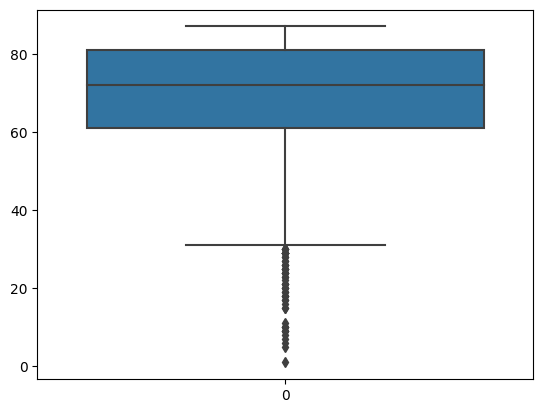

In [ ]:
sns.boxplot(df_train['CURRENT_ENERGY_EFFICIENCY'])

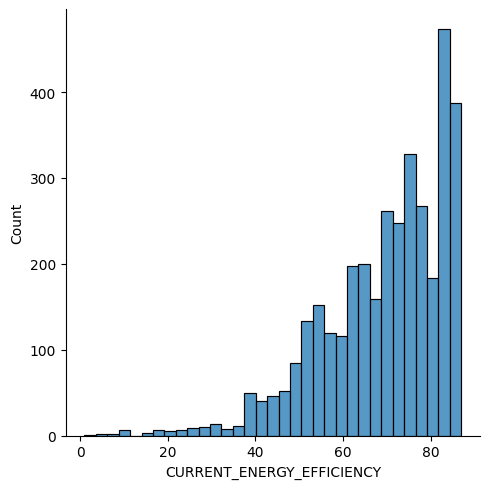

In [ ]:
sns.displot(df_train['CURRENT_ENERGY_EFFICIENCY'])

<Axes: >

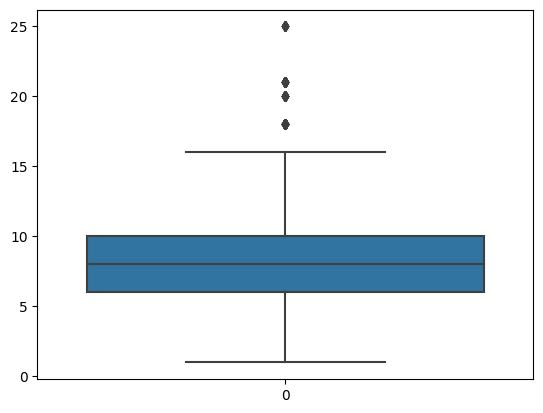

In [ ]:
sns.boxplot(df_train['FIXED_LIGHTING_OUTLETS_COUNT'])

<Axes: >

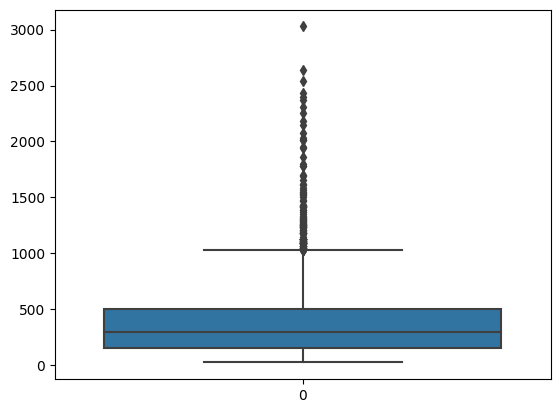

In [ ]:
sns.boxplot(df_train['HEATING_COST_CURRENT'])

##Multivariate Data Analysis

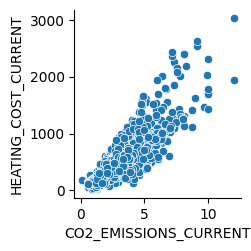

In [ ]:
sns.pairplot(df_train, x_vars='CO2_EMISSIONS_CURRENT', y_vars='HEATING_COST_CURRENT')

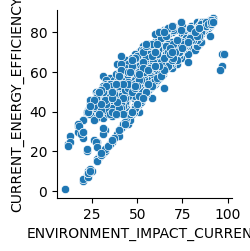

In [ ]:
sns.pairplot(df_train, x_vars='ENVIRONMENT_IMPACT_CURRENT', y_vars='CURRENT_ENERGY_EFFICIENCY')

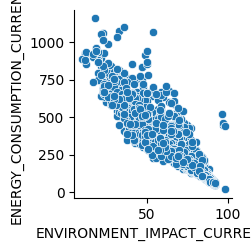

In [ ]:
sns.pairplot(df_train, x_vars='ENVIRONMENT_IMPACT_CURRENT', y_vars='ENERGY_CONSUMPTION_CURRENT')

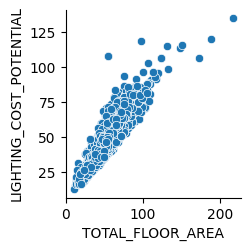

In [ ]:
sns.pairplot(df_train, x_vars='TOTAL_FLOOR_AREA', y_vars='LIGHTING_COST_POTENTIAL')

##Correlation Analysis

In [ ]:
corrTrain = df_train.corr()
corrTrain

<ipython-input-23-08843a386da9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrTrain = df_train.corr()


,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,COUNTY,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,...,NUMBER_OPEN_FIREPLACES,SHEATING_ENERGY_EFF,SHEATING_ENV_EFF,WIND_TURBINE_COUNT,UNHEATED_CORRIDOR_LENGTH,FLOOR_HEIGHT,PHOTO_SUPPLY,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN
BUILDING_REFERENCE_NUMBER,1.000000,0.240731,0.248466,NaN,0.258008,0.274427,-0.283890,-0.300977,-0.187213,-0.285932,...,0.007533,NaN,NaN,NaN,-0.050853,-0.029789,0.007328,-0.030753,-0.253177,0.119975
CURRENT_ENERGY_EFFICIENCY,0.240731,1.000000,0.717277,NaN,0.925814,0.811288,-0.884750,-0.726784,-0.855800,-0.887995,...,-0.029068,NaN,NaN,NaN,0.004751,-0.122560,0.001877,0.504967,0.459553,-0.113294
POTENTIAL_ENERGY_EFFICIENCY,0.248466,0.717277,1.000000,NaN,0.665908,0.775171,-0.646149,-0.733780,-0.579936,-0.655308,...,-0.024435,NaN,NaN,NaN,-0.017296,-0.104979,0.004307,0.464268,0.303722,0.009039
COUNTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENVIRONMENT_IMPACT_CURRENT,0.258008,0.925814,0.665908,NaN,1.000000,0.881936,-0.921806,-0.752753,-0.926019,-0.923998,...,-0.028149,NaN,NaN,NaN,-0.047395,-0.102325,0.030776,0.456749,0.302984,-0.170472
ENVIRONMENT_IMPACT_POTENTIAL,0.274427,0.811288,0.775171,NaN,0.881936,1.000000,-0.835675,-0.895730,-0.783134,-0.833684,...,-0.008296,NaN,NaN,NaN,0.001103,0.004552,0.058574,0.414747,0.148836,-0.029247
ENERGY_CONSUMPTION_CURRENT,-0.283890,-0.884750,-0.646149,NaN,-0.921806,-0.835675,1.000000,0.870955,0.775096,0.999486,...,0.016476,NaN,NaN,NaN,-0.012942,0.073413,-0.029087,-0.495512,-0.307722,0.035133
ENERGY_CONSUMPTION_POTENTIAL,-0.300977,-0.726784,-0.733780,NaN,-0.752753,-0.895730,0.870955,1.000000,0.561558,0.867844,...,-0.000639,NaN,NaN,NaN,-0.048835,-0.028244,-0.050152,-0.456845,-0.151288,-0.115947
CO2_EMISSIONS_CURRENT,-0.187213,-0.855800,-0.579936,NaN,-0.926019,-0.783134,0.775096,0.561558,1.000000,0.777236,...,0.023080,NaN,NaN,NaN,0.040968,0.127107,-0.025073,-0.328406,-0.317648,0.210066
CO2_EMISS_CURR_PER_FLOOR_AREA,-0.285932,-0.887995,-0.655308,NaN,-0.923998,-0.833684,0.999486,0.867844,0.777236,1.000000,...,0.018929,NaN,NaN,NaN,-0.009507,0.079184,-0.028689,-0.501783,-0.313414,0.044043


<Axes: >

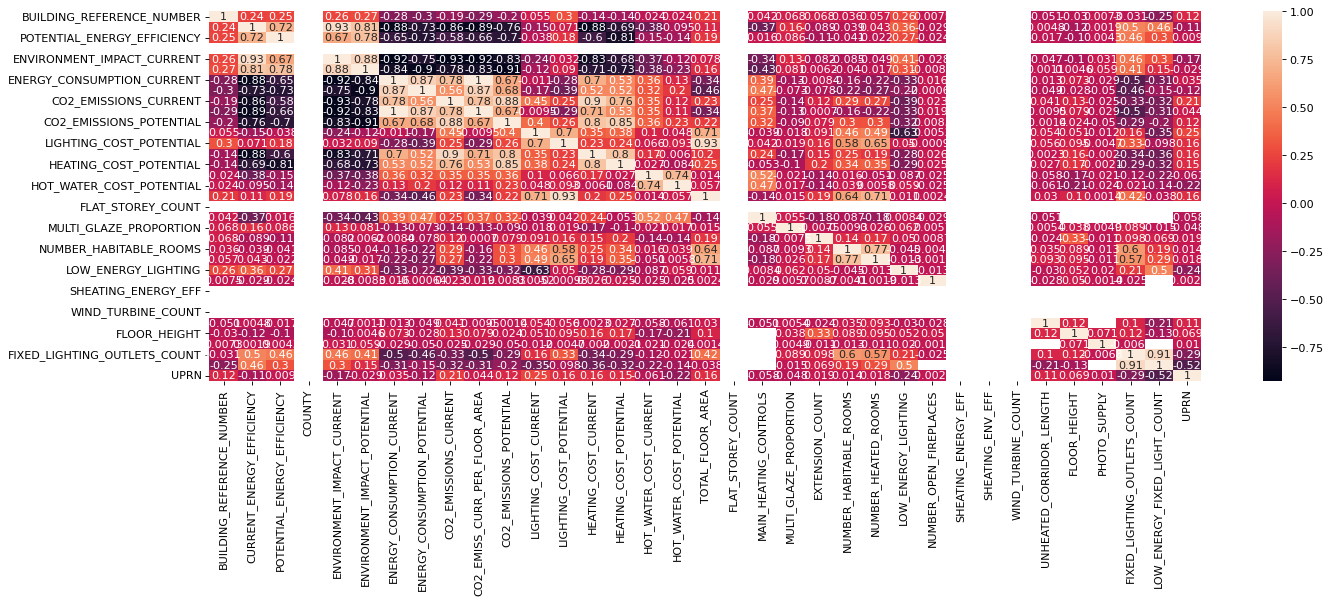

In [ ]:
plt.figure(figsize = (20, 6), dpi = 80)
sns.heatmap(corrTrain, annot=True)

#Data Pre-processing

##Data Cleaning

###Handing Missing Data

####Dropping columns and removing missing values from the training set

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3584 entries, 2211 to 860
Data columns (total 92 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LMK_KEY                        3584 non-null   object 
 1   ADDRESS1                       3584 non-null   object 
 2   ADDRESS2                       3163 non-null   object 
 3   ADDRESS3                       1362 non-null   object 
 4   POSTCODE                       3584 non-null   object 
 5   BUILDING_REFERENCE_NUMBER      3584 non-null   int64  
 6   POTENTIAL_ENERGY_RATING        3584 non-null   object 
 7   CURRENT_ENERGY_EFFICIENCY      3584 non-null   int64  
 8   POTENTIAL_ENERGY_EFFICIENCY    3584 non-null   int64  
 9   PROPERTY_TYPE                  3584 non-null   object 
 10  BUILT_FORM                     3584 non-null   object 
 11  INSPECTION_DATE                3584 non-null   object 
 12  LOCAL_AUTHORITY                3584 non-null  

Drop labels which are not required in the model or labels which cannot be used due to providing location or dates.

In [ ]:
df_train = df_train.drop(labels=['LMK_KEY', 'POSTCODE', 'BUILDING_REFERENCE_NUMBER', 'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL', 'POSTTOWN', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'COUNTY', 'FLAT_STOREY_COUNT', 'SHEATING_ENERGY_EFF', 'SHEATING_ENV_EFF', 'LOW_ENERGY_FIXED_LIGHT_COUNT', 'FLOOR_ENV_EFF','ADDRESS', 'UPRN', 'UPRN_SOURCE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'MAIN_HEATING_CONTROLS', 'PHOTO_SUPPLY', 'UNHEATED_CORRIDOR_LENGTH', 'ROOF_ENV_EFF', 'ROOF_ENERGY_EFF', 'FLOOR_ENERGY_EFF', 'POTENTIAL_ENERGY_RATING', 'INSPECTION_DATE', 'FLOOR_DESCRIPTION', 'LODGEMENT_DATE', 'LODGEMENT_DATETIME'], axis='columns')
df_train.head()

,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,...,MAIN_FUEL,WIND_TURBINE_COUNT,HEAT_LOSS_CORRIDOR,FLOOR_HEIGHT,SOLAR_WATER_HEATING_FLAG,MECHANICAL_VENTILATION,CONSTRUCTION_AGE_BAND,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,CURRENT_ENERGY_RATING
2211,82,82,Flat,Mid-Terrace,rental,87,87,116,116,0.8,...,mains gas (community),0.0,heated corridor,2.35,N,natural,England and Wales: 1983-1990,Rented (social),6.0,B
4248,64,75,Flat,End-Terrace,rental (private),68,69,272,266,2.1,...,To be used only when there is no heating/hot-w...,0.0,unheated corridor,NaN,N,natural,INVALID!,rental (private),NaN,D
100,72,75,Flat,Semi-Detached,rental,73,78,222,181,1.8,...,mains gas (not community),0.0,no corridor,2.43,N,natural,England and Wales: 1950-1966,Rented (social),6.0,C
12,72,72,Flat,Semi-Detached,rental,75,75,195,195,1.7,...,mains gas (not community),0.0,no corridor,2.45,N,natural,England and Wales: 1976-1982,Rented (social),6.0,C
2459,81,81,Flat,Semi-Detached,rental,83,83,125,125,1.3,...,mains gas (community),0.0,heated corridor,2.30,N,natural,England and Wales: 2012 onwards,Rented (social),7.0,B


In [ ]:
df_train.isnull().sum()

CURRENT_ENERGY_EFFICIENCY          0
POTENTIAL_ENERGY_EFFICIENCY        0
PROPERTY_TYPE                      0
BUILT_FORM                         0
TRANSACTION_TYPE                   0
                                ... 
MECHANICAL_VENTILATION           890
CONSTRUCTION_AGE_BAND             13
TENURE                             0
FIXED_LIGHTING_OUTLETS_COUNT    1232
CURRENT_ENERGY_RATING              0
Length: 61, dtype: int64

In [ ]:
pip install missingno

<Axes: >

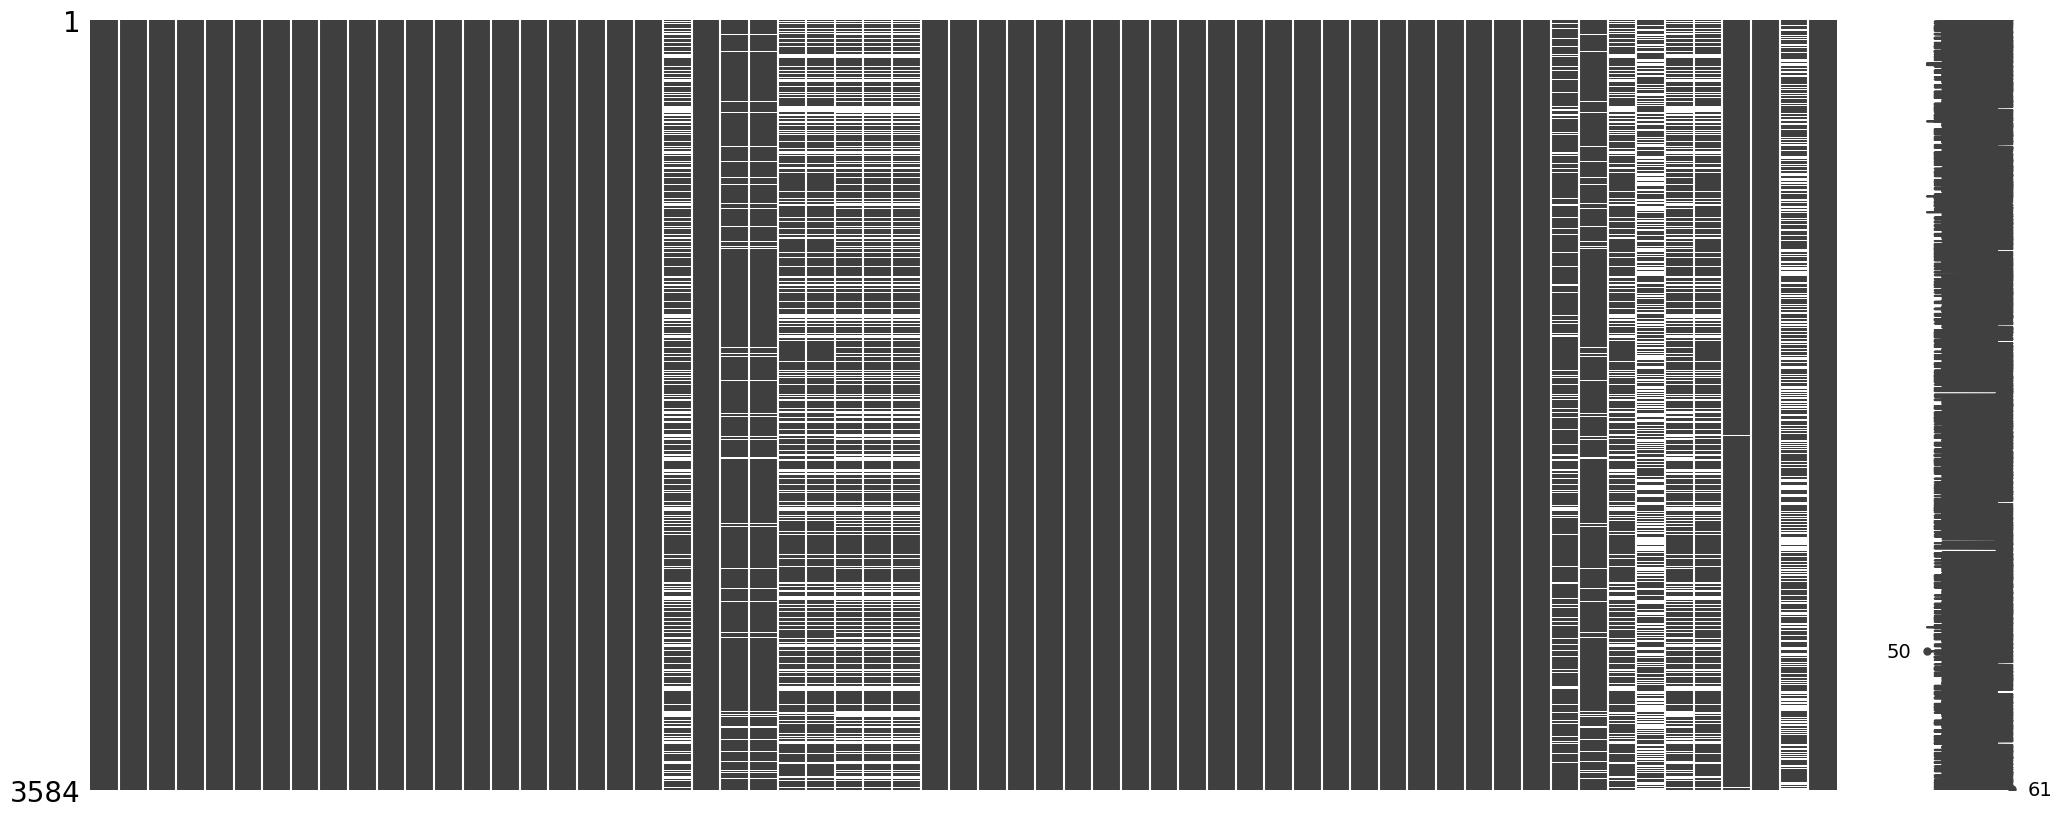

In [ ]:
import missingno as msno
msno.matrix(df_train)

In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train.shape

(1228, 61)

####Identify columns to drop and remove missing values from the validation set. This should be the same as the training set to ensure continuity is maintained.

In [ ]:
df_val = df_val.drop(labels=['LMK_KEY', 'POSTCODE', 'BUILDING_REFERENCE_NUMBER', 'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL', 'POSTTOWN', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'COUNTY', 'FLAT_STOREY_COUNT', 'SHEATING_ENERGY_EFF', 'SHEATING_ENV_EFF', 'LOW_ENERGY_FIXED_LIGHT_COUNT', 'FLOOR_ENV_EFF','ADDRESS', 'UPRN', 'UPRN_SOURCE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'MAIN_HEATING_CONTROLS', 'PHOTO_SUPPLY', 'UNHEATED_CORRIDOR_LENGTH', 'ROOF_ENV_EFF', 'ROOF_ENERGY_EFF', 'FLOOR_ENERGY_EFF', 'POTENTIAL_ENERGY_RATING', 'INSPECTION_DATE', 'FLOOR_DESCRIPTION', 'LODGEMENT_DATE', 'LODGEMENT_DATETIME'], axis='columns')
df_val.head()

,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,...,MAIN_FUEL,WIND_TURBINE_COUNT,HEAT_LOSS_CORRIDOR,FLOOR_HEIGHT,SOLAR_WATER_HEATING_FLAG,MECHANICAL_VENTILATION,CONSTRUCTION_AGE_BAND,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,CURRENT_ENERGY_RATING
2980,77,77,Flat,Semi-Detached,new dwelling,81,81,171,171,1.1,...,mains gas - this is for backwards compatibilit...,NaN,NO DATA!,NaN,NaN,NO DATA!,NO DATA!,unknown,25.0,C
2029,54,76,Flat,End-Terrace,ECO assessment,56,72,653,411,2.0,...,electricity (not community),0.0,heated corridor,2.3,N,natural,England and Wales: 1967-1975,Rented (private),4.0,E
3431,48,79,Flat,Semi-Detached,ECO assessment,41,65,444,240,5.2,...,electricity (not community),0.0,unheated corridor,NaN,N,natural,England and Wales: 1967-1975,rental (social),NaN,E
51,59,72,Flat,Mid-Terrace,rental,41,53,483,364,4.5,...,electricity (not community),0.0,unheated corridor,2.3,N,natural,England and Wales: 1967-1975,Rented (private),7.0,D
1488,82,82,Flat,Mid-Terrace,new dwelling,84,84,132,132,1.1,...,"Electricity: electricity, unspecified tariff",0.0,NaN,2.4,NaN,NaN,2017,Not defined - use in the case of a new dwellin...,10.0,B


In [ ]:
df_val = df_val.dropna()

In [ ]:
df_val.shape

(167, 61)

In [ ]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 2029 to 2475
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CURRENT_ENERGY_EFFICIENCY      167 non-null    int64  
 1   POTENTIAL_ENERGY_EFFICIENCY    167 non-null    int64  
 2   PROPERTY_TYPE                  167 non-null    object 
 3   BUILT_FORM                     167 non-null    object 
 4   TRANSACTION_TYPE               167 non-null    object 
 5   ENVIRONMENT_IMPACT_CURRENT     167 non-null    int64  
 6   ENVIRONMENT_IMPACT_POTENTIAL   167 non-null    int64  
 7   ENERGY_CONSUMPTION_CURRENT     167 non-null    int64  
 8   ENERGY_CONSUMPTION_POTENTIAL   167 non-null    int64  
 9   CO2_EMISSIONS_CURRENT          167 non-null    float64
 10  CO2_EMISS_CURR_PER_FLOOR_AREA  167 non-null    int64  
 11  CO2_EMISSIONS_POTENTIAL        167 non-null    float64
 12  LIGHTING_COST_CURRENT          167 non-null   

In [ ]:
df_test = df_test.drop(labels=['LMK_KEY', 'POSTCODE', 'BUILDING_REFERENCE_NUMBER', 'LOCAL_AUTHORITY_LABEL', 'CONSTITUENCY_LABEL', 'POSTTOWN', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'COUNTY', 'FLAT_STOREY_COUNT', 'SHEATING_ENERGY_EFF', 'SHEATING_ENV_EFF', 'LOW_ENERGY_FIXED_LIGHT_COUNT', 'FLOOR_ENV_EFF','ADDRESS', 'UPRN', 'UPRN_SOURCE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'MAIN_HEATING_CONTROLS', 'PHOTO_SUPPLY', 'UNHEATED_CORRIDOR_LENGTH', 'ROOF_ENV_EFF', 'ROOF_ENERGY_EFF', 'FLOOR_ENERGY_EFF', 'POTENTIAL_ENERGY_RATING', 'INSPECTION_DATE', 'FLOOR_DESCRIPTION', 'LODGEMENT_DATE', 'LODGEMENT_DATETIME'], axis='columns')
df_test.head()

,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,...,MAIN_FUEL,WIND_TURBINE_COUNT,HEAT_LOSS_CORRIDOR,FLOOR_HEIGHT,SOLAR_WATER_HEATING_FLAG,MECHANICAL_VENTILATION,CONSTRUCTION_AGE_BAND,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,CURRENT_ENERGY_RATING
3299,34,53,Flat,Mid-Terrace,rental (private),43,58,433,302,4.8,...,electricity (not community),0.0,unheated corridor,NaN,N,natural,England and Wales: 1967-1975,rental (private),NaN,F
1972,29,76,Flat,Semi-Detached,marketed sale,19,59,961,361,6.6,...,electricity (not community),0.0,no corridor,3.04,N,natural,England and Wales: 1900-1929,Owner-occupied,4.0,F
318,77,77,Flat,Semi-Detached,rental,81,81,156,156,1.3,...,mains gas (not community),0.0,unheated corridor,2.39,N,natural,England and Wales: 1996-2002,Rented (social),7.0,C
2663,76,76,Flat,Detached,new dwelling,82,82,194,194,0.9,...,NO DATA!,NaN,NO DATA!,NaN,NaN,NO DATA!,NO DATA!,unknown,1.0,C
2407,43,75,Flat,End-Terrace,rental,49,68,443,275,3.3,...,electricity (not community),0.0,unheated corridor,2.58,N,natural,England and Wales: 1900-1929,Rented (private),6.0,E


In [ ]:
df_test.dropna()

,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,...,MAIN_FUEL,WIND_TURBINE_COUNT,HEAT_LOSS_CORRIDOR,FLOOR_HEIGHT,SOLAR_WATER_HEATING_FLAG,MECHANICAL_VENTILATION,CONSTRUCTION_AGE_BAND,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,CURRENT_ENERGY_RATING
1972,29,76,Flat,Semi-Detached,marketed sale,19,59,961,361,6.6,...,electricity (not community),0.0,no corridor,3.04,N,natural,England and Wales: 1900-1929,Owner-occupied,4.0,F
318,77,77,Flat,Semi-Detached,rental,81,81,156,156,1.3,...,mains gas (not community),0.0,unheated corridor,2.39,N,natural,England and Wales: 1996-2002,Rented (social),7.0,C
2407,43,75,Flat,End-Terrace,rental,49,68,443,275,3.3,...,electricity (not community),0.0,unheated corridor,2.58,N,natural,England and Wales: 1900-1929,Rented (private),6.0,E
1123,76,76,Flat,Semi-Detached,rental,77,77,166,166,1.8,...,mains gas (not community),0.0,no corridor,2.40,N,natural,England and Wales: 1950-1966,Rented (social),7.0,C
175,74,83,Flat,Semi-Detached,rental,71,75,212,185,2.2,...,electricity (not community),0.0,unheated corridor,2.40,N,natural,England and Wales: 1976-1982,Rented (social),7.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,64,75,Flat,Semi-Detached,rental,61,77,306,180,2.6,...,mains gas (not community),0.0,unheated corridor,3.06,N,natural,England and Wales: before 1900,Rented (social),5.0,D
220,78,79,Flat,Mid-Terrace,rental,81,83,153,136,1.2,...,mains gas (not community),0.0,no corridor,2.32,N,natural,England and Wales: 1983-1990,Rented (social),8.0,C
1907,69,79,Flat,Semi-Detached,rental,69,83,256,145,2.0,...,mains gas (not community),0.0,unheated corridor,2.83,N,natural,England and Wales: 1900-1929,Rented (social),7.0,C
461,80,81,Flat,Mid-Terrace,marketed sale,84,85,134,130,1.0,...,mains gas (community),0.0,heated corridor,2.34,N,natural,England and Wales: 1991-1995,Owner-occupied,6.0,C


####Identify which attributes require encoding before modelling can take place - Training Set

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1228 entries, 2211 to 466
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CURRENT_ENERGY_EFFICIENCY      1228 non-null   int64  
 1   POTENTIAL_ENERGY_EFFICIENCY    1228 non-null   int64  
 2   PROPERTY_TYPE                  1228 non-null   object 
 3   BUILT_FORM                     1228 non-null   object 
 4   TRANSACTION_TYPE               1228 non-null   object 
 5   ENVIRONMENT_IMPACT_CURRENT     1228 non-null   int64  
 6   ENVIRONMENT_IMPACT_POTENTIAL   1228 non-null   int64  
 7   ENERGY_CONSUMPTION_CURRENT     1228 non-null   int64  
 8   ENERGY_CONSUMPTION_POTENTIAL   1228 non-null   int64  
 9   CO2_EMISSIONS_CURRENT          1228 non-null   float64
 10  CO2_EMISS_CURR_PER_FLOOR_AREA  1228 non-null   int64  
 11  CO2_EMISSIONS_POTENTIAL        1228 non-null   float64
 12  LIGHTING_COST_CURRENT          1228 non-null  

In [ ]:
def create_dummies(df, column_name,drop_first=False):
  # Get the binary encodings for the columns
  temp_dummies = pd.get_dummies(df_train[column_name],drop_first=drop_first)
  temp_df = df_train.drop(labels=[column_name], axis='columns')
  return temp_df.join(temp_dummies, how = 'left', lsuffix='left', rsuffix='right')

In [ ]:
lst2 = ['BUILT_FORM', 'TRANSACTION_TYPE', 'ENERGY_TARIFF', 'MAINS_GAS_FLAG', 'FLOOR_LEVEL', 'FLAT_TOP_STOREY', 'GLAZED_TYPE', 'GLAZED_AREA', 'HOTWATER_DESCRIPTION', 'HOT_WATER_ENERGY_EFF', 'HOT_WATER_ENV_EFF', 'WINDOWS_DESCRIPTION', 'WINDOWS_ENERGY_EFF', 'WINDOWS_ENV_EFF', 'WALLS_DESCRIPTION', 'WALLS_ENERGY_EFF', 'WALLS_ENV_EFF', 'SECONDHEAT_DESCRIPTION', 'ROOF_DESCRIPTION', 'MAINHEAT_DESCRIPTION', 'MAINHEAT_ENERGY_EFF', 'MAINHEAT_ENV_EFF', 'MAINHEATCONT_DESCRIPTION', 'MAINHEATC_ENERGY_EFF', 'MAINHEATC_ENV_EFF', 'LIGHTING_DESCRIPTION', 'LIGHTING_ENERGY_EFF', 'LIGHTING_ENV_EFF', 'MAIN_FUEL', 'HEAT_LOSS_CORRIDOR', 'SOLAR_WATER_HEATING_FLAG', 'MECHANICAL_VENTILATION', 'CONSTRUCTION_AGE_BAND', 'TENURE', 'PROPERTY_TYPE', 'FLOOR_DESCRIPTION']

In [ ]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 2029 to 2475
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CURRENT_ENERGY_EFFICIENCY      167 non-null    int64  
 1   POTENTIAL_ENERGY_EFFICIENCY    167 non-null    int64  
 2   PROPERTY_TYPE                  167 non-null    object 
 3   BUILT_FORM                     167 non-null    object 
 4   TRANSACTION_TYPE               167 non-null    object 
 5   ENVIRONMENT_IMPACT_CURRENT     167 non-null    int64  
 6   ENVIRONMENT_IMPACT_POTENTIAL   167 non-null    int64  
 7   ENERGY_CONSUMPTION_CURRENT     167 non-null    int64  
 8   ENERGY_CONSUMPTION_POTENTIAL   167 non-null    int64  
 9   CO2_EMISSIONS_CURRENT          167 non-null    float64
 10  CO2_EMISS_CURR_PER_FLOOR_AREA  167 non-null    int64  
 11  CO2_EMISSIONS_POTENTIAL        167 non-null    float64
 12  LIGHTING_COST_CURRENT          167 non-null   

In [ ]:
for i in range(0, len(lst2)-1, 1):
  df_val = create_dummies(df_val, lst2[i])
  df_test = create_dummies(df_test, lst2[i])
  df_train = create_dummies(df_train, lst2[i])


<ipython-input-39-c6cf5290668b>:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Averageleft', 'Poorleft', 'Very Poorleft', 'Goodleft'} in the result is deprecated and will raise a MergeError in a future version.
  return temp_df.join(temp_dummies, how = 'left', lsuffix='left', rsuffix='right')
<ipython-input-39-c6cf5290668b>:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Averageleft', 'Poorleft', 'Very Poorleft', 'Goodleft'} in the result is deprecated and will raise a MergeError in a future version.
  return temp_df.join(temp_dummies, how = 'left', lsuffix='left', rsuffix='right')
<ipython-input-39-c6cf5290668b>:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Averageleft', 'Poorleft', 'Very Poorleft', 'Goodleft'} in the result is deprecated and will raise a MergeError in a future version.
  return temp_df.join(temp_dummies, how = 'left', lsuffix='left', rsuffix='right')
<ipython-input-39-c6cf5290668b>:5: FutureWarning: Pa

After the encoding check that only the target attribute hasn't been dummies encoded as this will be encoded using a different encoder.

In [ ]:
df_train.select_dtypes(include=object)

,CURRENT_ENERGY_RATING
2211,B
100,C
12,C
2459,B
217,C
...,...
474,C
2433,B
1685,F
130,D


In [ ]:
df_train.shape

(1228, 295)

In [ ]:
df_val.shape

(1228, 295)

In [ ]:
df_test.shape

(1228, 295)

####Identify which attributes require encoding before modelling can take place - Validation Set

In [ ]:
df_val.select_dtypes(include=object)

,CURRENT_ENERGY_RATING
2211,B
100,C
12,C
2459,B
217,C
...,...
474,C
2433,B
1685,F
130,D


In [ ]:
df_test.select_dtypes(include=object)

,CURRENT_ENERGY_RATING
2211,B
100,C
12,C
2459,B
217,C
...,...
474,C
2433,B
1685,F
130,D


###Handling Noisy Data

###Handling Outliers

##Data Transformation

###Data Encoding

###Data Scaling

In [ ]:
y_train = df_train['CURRENT_ENERGY_RATING']
X_train = df_train.drop(labels=['CURRENT_ENERGY_RATING'], axis='columns')

In [ ]:
y_val = df_val['CURRENT_ENERGY_RATING']
X_val = df_val.drop(labels=['CURRENT_ENERGY_RATING'], axis='columns')

In [ ]:
y_test = df_test['CURRENT_ENERGY_RATING']
X_test = df_test.drop(labels=['CURRENT_ENERGY_RATING'], axis='columns')

In [ ]:
le = LabelEncoder()

In [ ]:
le.fit(y_train)

LabelEncoder()

In [ ]:
list(le.classes_)

['B', 'C', 'D', 'E', 'F', 'G']

In [ ]:
y_train = le.transform(y_train)
y_train

array([0, 1, 1, ..., 4, 2, 1])

In [ ]:
y_train = pd.DataFrame(y_train, columns=['CURRENT_ENERGY_RATING'])
y_train

,CURRENT_ENERGY_RATING
0,0
1,1
2,1
3,0
4,1
...,...
1223,1
1224,0
1225,4
1226,2


In [ ]:
le.fit(y_val)

LabelEncoder()

In [ ]:
y_val = le.transform(y_val)

In [ ]:
y_val = pd.DataFrame(y_val, columns=['CURRENT_ENERGY_RATING'])

In [ ]:
le.fit(y_test)

LabelEncoder()

In [ ]:
y_test = le.transform(y_test)

In [ ]:
y_test = pd.DataFrame(y_test, columns=['CURRENT_ENERGY_RATING'])

In [ ]:
target_names = ['B','C','D','E','F', 'G']

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']

In [ ]:
X_train.columns

Index(['CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY',
       'ENVIRONMENT_IMPACT_CURRENT', 'ENVIRONMENT_IMPACT_POTENTIAL',
       'ENERGY_CONSUMPTION_CURRENT', 'ENERGY_CONSUMPTION_POTENTIAL',
       'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
       'CO2_EMISSIONS_POTENTIAL', 'LIGHTING_COST_CURRENT',
       ...
       'England and Wales: 1996-2002', 'England and Wales: 2003-2006',
       'England and Wales: 2007-2011', 'England and Wales: 2012 onwards',
       'England and Wales: before 1900',
       'Not defined - use in the case of a new dwelling for which the intended tenure in not known. It is no',
       'Owner-occupied', 'Rented (private)', 'Rented (social)', 'Flat'],
      dtype='object', length=294)

In [ ]:
X_test.shape

(1228, 294)

#Model Building - Random Forest

##Training Data

In [ ]:
rf = RandomForestClassifier( max_depth=5, random_state=42, n_estimators = 10)

In [ ]:
start = time.time()

In [ ]:
rf.fit(X_train, y_train)

<ipython-input-69-168a6fc83696>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

In [ ]:
end = time.time()

In [ ]:
timeTaken = end-start
timeTaken

0.08159422874450684

##Validating RF Data

In [ ]:
rf_val_pred = rf.predict(X_val)

In [ ]:
rf_val_acc = accuracy_score(y_val, rf_val_pred)
rf_val_prec = precision_score(y_val, rf_val_pred, average='weighted')
rf_val_rec = recall_score(y_val, rf_val_pred, average='weighted')
rf_val_f1 = f1_score(y_val, rf_val_pred, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(rf_val_acc, '\n', rf_val_prec, '\n', rf_val_rec, '\n', rf_val_f1)

0.9112377850162866 
 0.9072888616598346 
 0.9112377850162866 
 0.9032687431623089


In [ ]:
rf_val_clfrprt = classification_report(y_val, rf_val_pred, target_names=target_names)
print(rf_val_clfrprt)

              precision    recall  f1-score   support

           B       1.00      0.56      0.72        41
           C       0.94      0.97      0.96       516
           D       0.91      0.95      0.93       437
           E       0.83      0.85      0.84       195
           F       1.00      0.37      0.54        30
           G       0.00      0.00      0.00         9

    accuracy                           0.91      1228
   macro avg       0.78      0.62      0.66      1228
weighted avg       0.91      0.91      0.90      1228



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rf_confmatrix = confusion_matrix(y_val, rf_val_pred)
rf_confmatrix

array([[ 23,  18,   0,   0,   0,   0],
       [  0, 503,  13,   0,   0,   0],
       [  0,  13, 416,   8,   0,   0],
       [  0,   0,  29, 166,   0,   0],
       [  0,   0,   0,  19,  11,   0],
       [  0,   0,   1,   8,   0,   0]])

In [ ]:
rf_confmatrix_df = pd.DataFrame(rf_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])

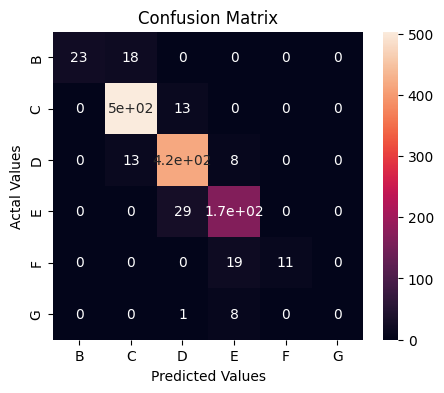

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(rf_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
rf_multi_confusion = multilabel_confusion_matrix(y_val, rf_val_pred)
rf_multi_confusion

array([[[1187,    0],
        [  18,   23]],

       [[ 681,   31],
        [  13,  503]],

       [[ 748,   43],
        [  21,  416]],

       [[ 998,   35],
        [  29,  166]],

       [[1198,    0],
        [  19,   11]],

       [[1219,    0],
        [   9,    0]]])

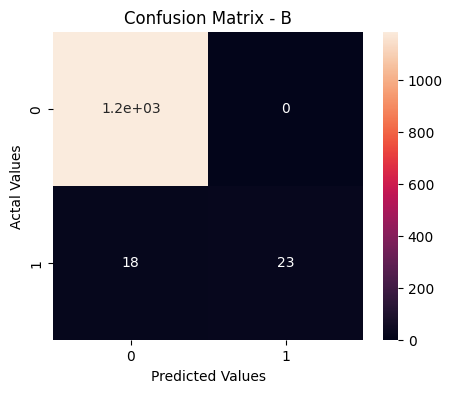

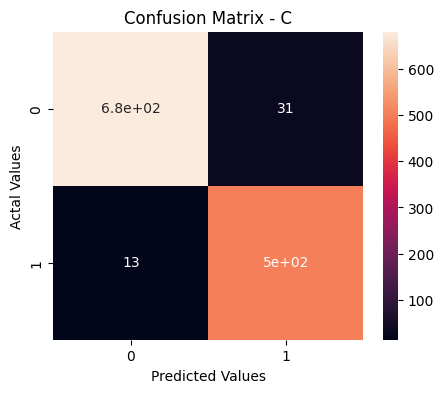

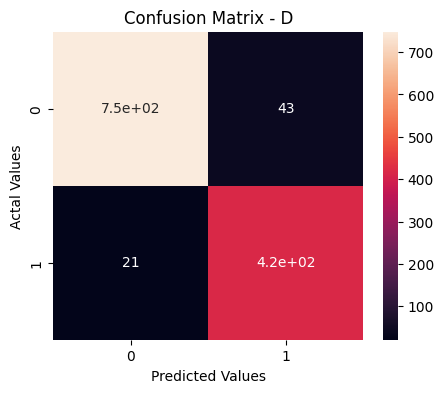

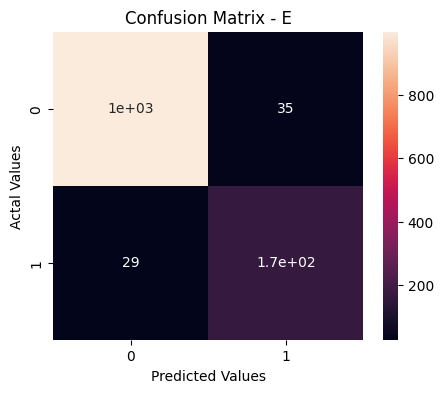

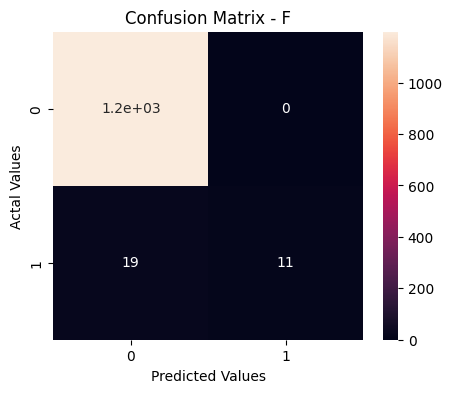

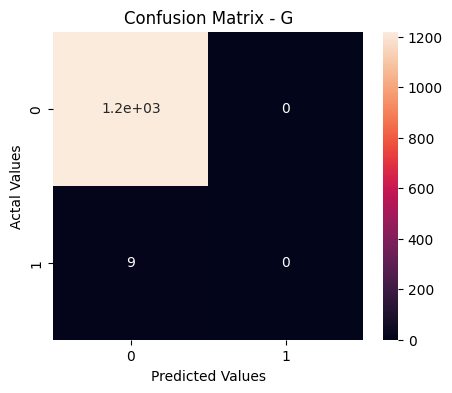

In [ ]:
for i in range (0, 6, 1):
  plt.figure(figsize=(5,4))
  sns.heatmap(rf_multi_confusion[i], annot=True)
  plt.title('Confusion Matrix - ' + target_names[i])
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  print('\n')

##Model Testing - RF

In [ ]:
rf_test_pred = rf.predict(X_test)

In [ ]:
rf_test_acc = accuracy_score(y_test, rf_test_pred)
rf_test_prec = precision_score(y_test, rf_test_pred, average='weighted')
rf_test_rec = recall_score(y_test, rf_test_pred, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_pred, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(rf_test_acc, '\n', rf_test_prec, '\n', rf_test_rec, '\n', rf_test_f1)

0.9112377850162866 
 0.9072888616598346 
 0.9112377850162866 
 0.9032687431623089


In [ ]:
rf_test_clfrprt = classification_report(y_test, rf_test_pred, target_names=target_names)
print(rf_test_clfrprt)

              precision    recall  f1-score   support

           B       1.00      0.56      0.72        41
           C       0.94      0.97      0.96       516
           D       0.91      0.95      0.93       437
           E       0.83      0.85      0.84       195
           F       1.00      0.37      0.54        30
           G       0.00      0.00      0.00         9

    accuracy                           0.91      1228
   macro avg       0.78      0.62      0.66      1228
weighted avg       0.91      0.91      0.90      1228



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rf_confmatrix = confusion_matrix(y_test, rf_test_pred)
rf_confmatrix

array([[ 23,  18,   0,   0,   0,   0],
       [  0, 503,  13,   0,   0,   0],
       [  0,  13, 416,   8,   0,   0],
       [  0,   0,  29, 166,   0,   0],
       [  0,   0,   0,  19,  11,   0],
       [  0,   0,   1,   8,   0,   0]])

In [ ]:
rf_confmatrix_df = pd.DataFrame(rf_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])

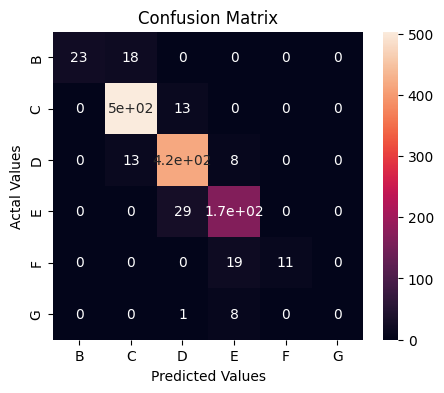

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(rf_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

##Model Explainability -  Shapley Additive Explanation (SHAP)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
import shap
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs()

# Create the explainer
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_test)

Variable Importance Plot - Global Interpretation


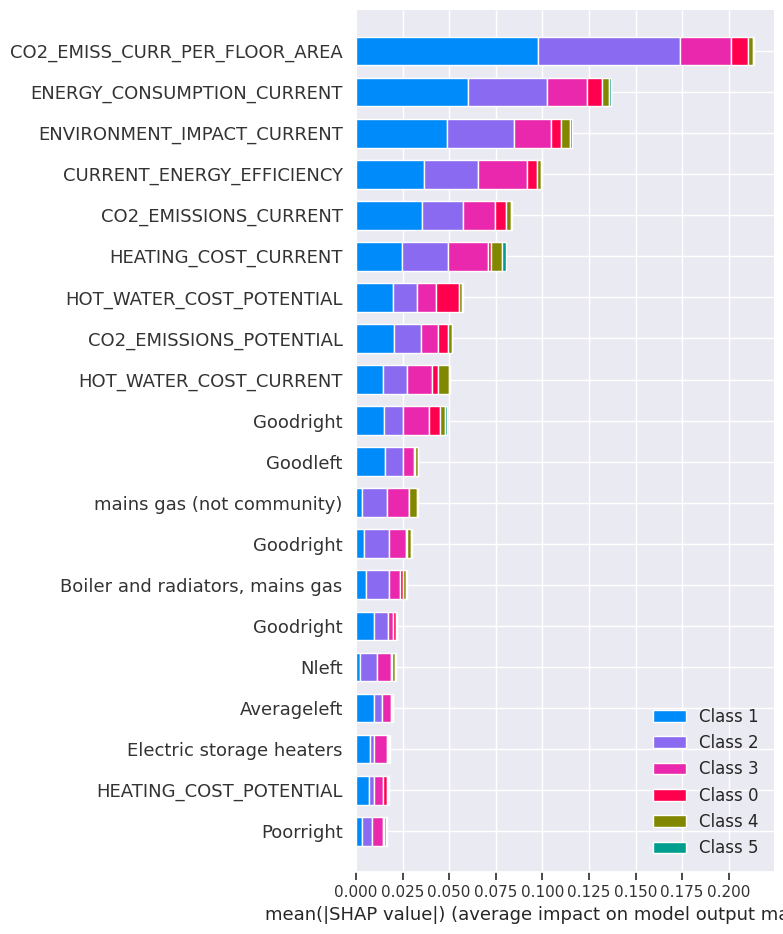

In [ ]:
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test)

#Model Building - K Nearest Neighbour

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

##Training Data

In [ ]:
knnStart = time.time()

In [ ]:
train_knn = knn.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
knnEnd = time.time()

In [ ]:
knnTimeTaken = knnEnd - knnStart
knnTimeTaken

0.05541229248046875

In [ ]:
timeTaken

0.08159422874450684

##Validating Data

In [ ]:
knn_val_pred = knn.predict(X_val)

In [ ]:
knn_val_acc = accuracy_score(y_val, knn_val_pred)
knn_val_prec = precision_score(y_val, knn_val_pred, average='weighted')
knn_val_rec = recall_score(y_val, knn_val_pred, average='weighted')
knn_val_f1 = f1_score(y_val, knn_val_pred, average='weighted')

In [ ]:
print(knn_val_acc, '\n', knn_val_prec, '\n', knn_val_rec, '\n', knn_val_f1)

0.9267100977198697 
 0.9261167999875292 
 0.9267100977198697 
 0.9262511660759922


In [ ]:
knn_val_clfrprt = classification_report(y_val, knn_val_pred, target_names=target_names)
print(knn_val_clfrprt)

              precision    recall  f1-score   support

           B       0.89      0.83      0.86        41
           C       0.95      0.97      0.96       516
           D       0.93      0.92      0.93       437
           E       0.89      0.89      0.89       195
           F       0.77      0.77      0.77        30
           G       0.71      0.56      0.63         9

    accuracy                           0.93      1228
   macro avg       0.86      0.82      0.84      1228
weighted avg       0.93      0.93      0.93      1228



In [ ]:
knn_confmatrix = confusion_matrix(y_val, knn_val_pred)
knn_confmatrix

array([[ 34,   7,   0,   0,   0,   0],
       [  4, 500,  12,   0,   0,   0],
       [  0,  19, 403,  15,   0,   0],
       [  0,   0,  17, 173,   4,   1],
       [  0,   0,   0,   6,  23,   1],
       [  0,   0,   0,   1,   3,   5]])

In [ ]:
knn_confmatrix_df = pd.DataFrame(knn_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])

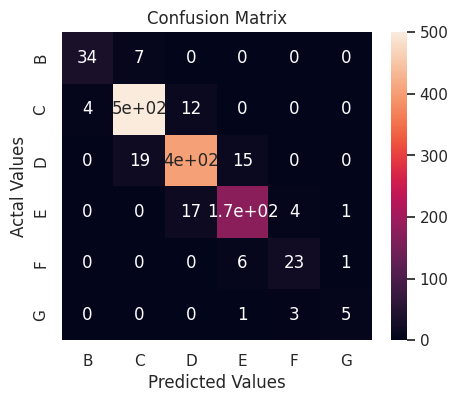

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(knn_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
knn_multi_confusion = multilabel_confusion_matrix(y_val, knn_val_pred)
knn_multi_confusion

array([[[1183,    4],
        [   7,   34]],

       [[ 686,   26],
        [  16,  500]],

       [[ 762,   29],
        [  34,  403]],

       [[1011,   22],
        [  22,  173]],

       [[1191,    7],
        [   7,   23]],

       [[1217,    2],
        [   4,    5]]])

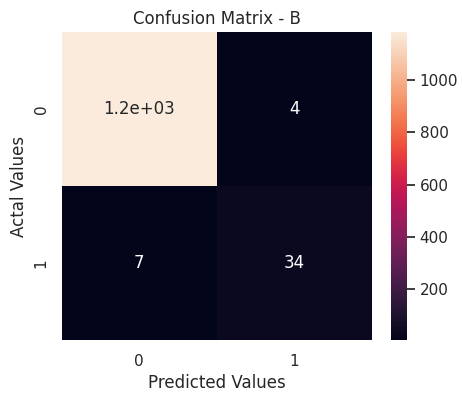

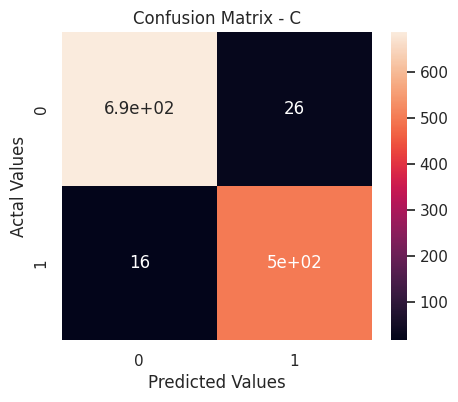

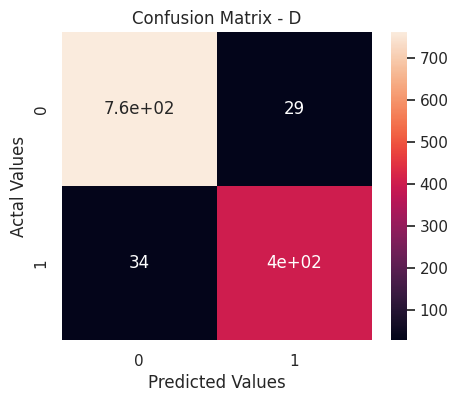

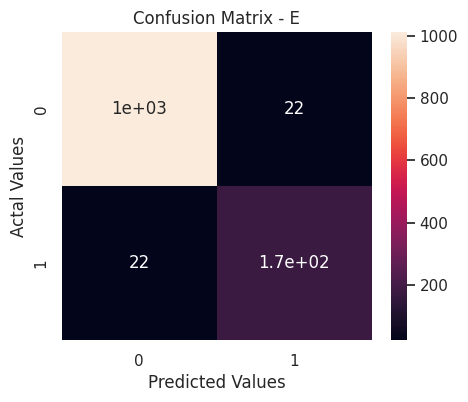

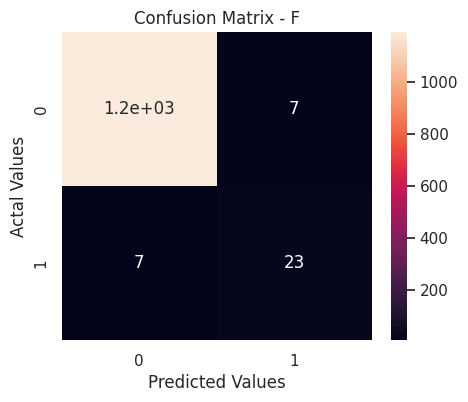

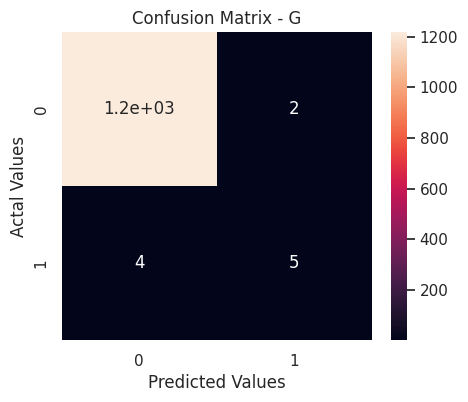

In [ ]:
for i in range (0, 6, 1):
  plt.figure(figsize=(5,4))
  sns.heatmap(knn_multi_confusion[i], annot=True)
  plt.title('Confusion Matrix - ' + target_names[i])
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  print('\n')

##Model Testing - KNN

In [ ]:
knn_test_pred = knn.predict(X_test)

In [ ]:
knn_test_acc = accuracy_score(y_test, knn_test_pred)
knn_test_prec = precision_score(y_test, knn_test_pred, average='weighted')
knn_test_rec = recall_score(y_test, knn_test_pred, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_pred, average='weighted')

In [ ]:
print(knn_test_acc, '\n', knn_test_prec, '\n', knn_test_rec, '\n', knn_test_f1)

0.9267100977198697 
 0.9261167999875292 
 0.9267100977198697 
 0.9262511660759922


In [ ]:
knn_test_clfrprt = classification_report(y_test, knn_test_pred, target_names=target_names)
print(knn_test_clfrprt)

              precision    recall  f1-score   support

           B       0.89      0.83      0.86        41
           C       0.95      0.97      0.96       516
           D       0.93      0.92      0.93       437
           E       0.89      0.89      0.89       195
           F       0.77      0.77      0.77        30
           G       0.71      0.56      0.63         9

    accuracy                           0.93      1228
   macro avg       0.86      0.82      0.84      1228
weighted avg       0.93      0.93      0.93      1228



In [ ]:
knn_confmatrix = confusion_matrix(y_test, knn_test_pred)
knn_confmatrix

array([[ 34,   7,   0,   0,   0,   0],
       [  4, 500,  12,   0,   0,   0],
       [  0,  19, 403,  15,   0,   0],
       [  0,   0,  17, 173,   4,   1],
       [  0,   0,   0,   6,  23,   1],
       [  0,   0,   0,   1,   3,   5]])

In [ ]:
knn_confmatrix_df = pd.DataFrame(knn_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])

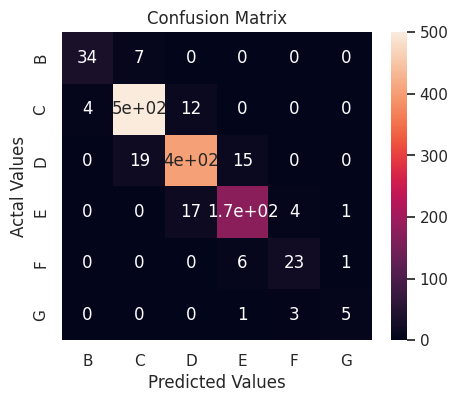

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(knn_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

##Model Explainability -  KNN Feature Importance


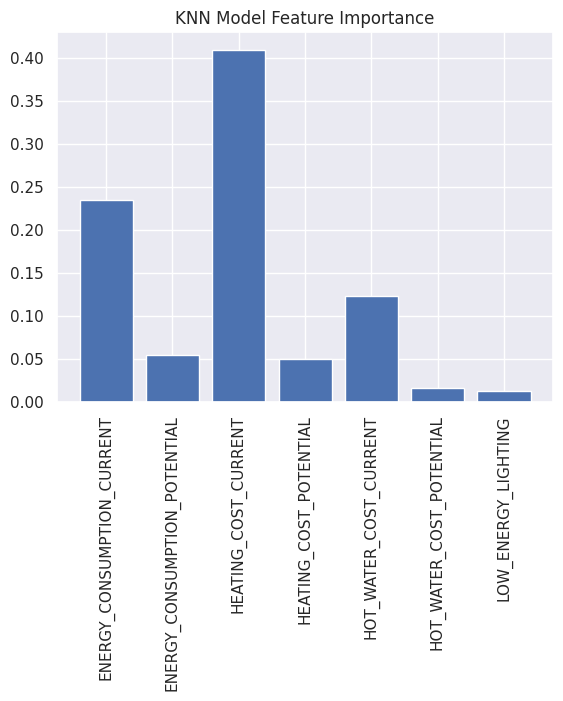

In [ ]:
# permutation feature importance with knn for classification
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

# perform permutation importance
results = permutation_importance(train_knn, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

# summarize feature importance in Pandas Data Frame
feature_df = pd.DataFrame({'Importance':importance, 'Features': X_train.columns })
feature_df = feature_df[feature_df['Importance'] > 0.01]

# plot feature importance
sns.set()
plt.bar(feature_df['Features'],  feature_df['Importance'])
plt.xticks(rotation=90)
plt.title('KNN Model Feature Importance')
plt.show()

#Model Building - Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state=42)

##Training Data

In [ ]:
svmStart = time.time()

In [ ]:
train_svm = svm.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
svmEnd = time.time()

In [ ]:
svmTimeTaken = svmEnd - svmStart
svmTimeTaken

0.13318419456481934

##Validating Data

In [ ]:
svm_val_pred = svm.predict(X_val)

In [ ]:
svm_val_acc = accuracy_score(y_val, svm_val_pred)
svm_val_prec = precision_score(y_val, svm_val_pred, average='weighted')
svm_val_rec = recall_score(y_val, svm_val_pred, average='weighted')
svm_val_f1 = f1_score(y_val, svm_val_pred, average='weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
print(svm_val_acc, '\n', svm_val_prec, '\n', svm_val_rec, '\n', svm_val_f1)

0.8363192182410424 
 0.8083135005079718 
 0.8363192182410424 
 0.8208980920769176


In [ ]:
svm_val_clfrprt = classification_report(y_val, svm_val_pred, target_names=target_names)
print(svm_val_clfrprt)

              precision    recall  f1-score   support

           B       0.00      0.00      0.00        41
           C       0.83      0.93      0.88       516
           D       0.85      0.83      0.84       437
           E       0.83      0.83      0.83       195
           F       0.77      0.67      0.71        30
           G       0.83      0.56      0.67         9

    accuracy                           0.84      1228
   macro avg       0.69      0.63      0.65      1228
weighted avg       0.81      0.84      0.82      1228



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
svm_confmatrix = confusion_matrix(y_val, svm_val_pred)
svm_confmatrix

array([[  0,  41,   0,   0,   0,   0],
       [  0, 480,  36,   0,   0,   0],
       [  0,  54, 361,  22,   0,   0],
       [  0,   0,  30, 161,   3,   1],
       [  0,   0,   0,  10,  20,   0],
       [  0,   0,   0,   1,   3,   5]])

In [ ]:
svm_confmatrix_df = pd.DataFrame(svm_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])

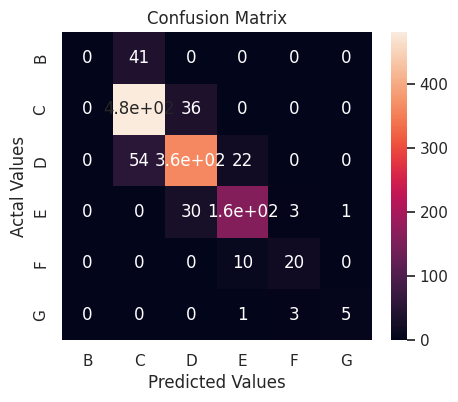

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(svm_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
svm_multi_confusion = multilabel_confusion_matrix(y_val, svm_val_pred)
svm_multi_confusion

array([[[1187,    0],
        [  41,    0]],

       [[ 617,   95],
        [  36,  480]],

       [[ 725,   66],
        [  76,  361]],

       [[1000,   33],
        [  34,  161]],

       [[1192,    6],
        [  10,   20]],

       [[1218,    1],
        [   4,    5]]])

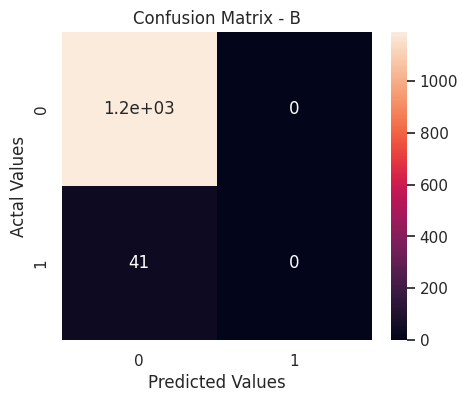

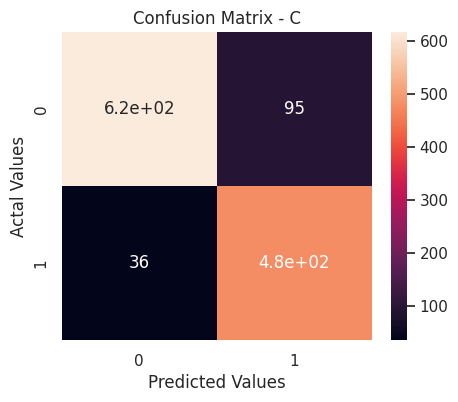

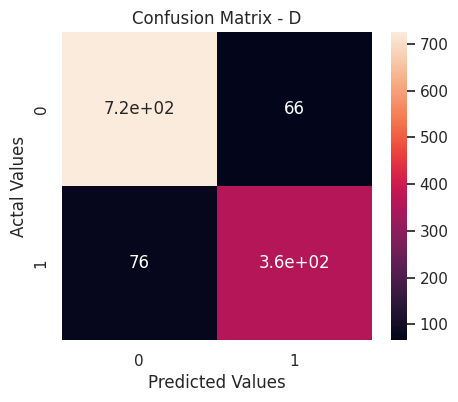

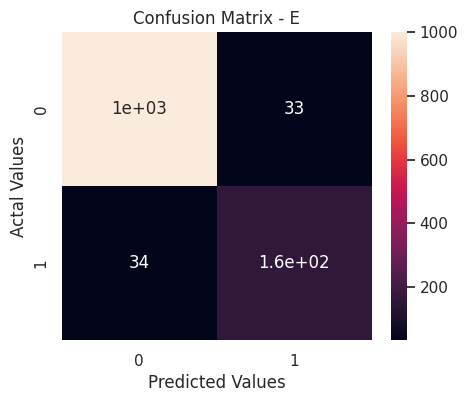

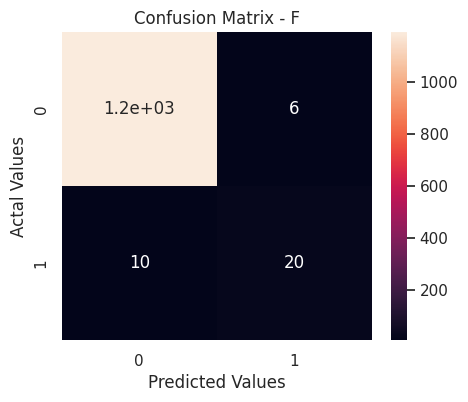

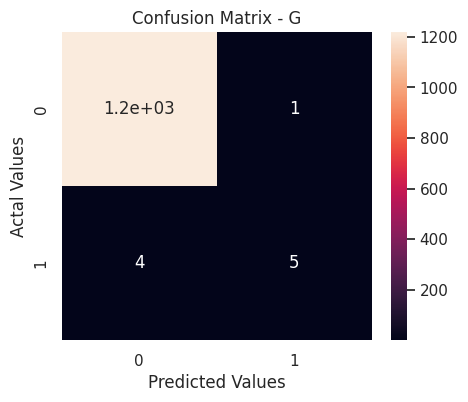

In [ ]:
for i in range (0, 6, 1):
  plt.figure(figsize=(5,4))
  sns.heatmap(svm_multi_confusion[i], annot=True)
  plt.title('Confusion Matrix - ' + target_names[i])
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  print('\n')

##Model Testing - SVM

In [ ]:
svm_test_pred = svm.predict(X_test)

In [ ]:
svm_test_acc = accuracy_score(y_test, svm_test_pred)
svm_test_prec = precision_score(y_test, svm_test_pred, average='weighted')
svm_test_rec = recall_score(y_test, svm_test_pred, average='weighted')
svm_test_f1 = f1_score(y_test, svm_test_pred, average='weighted')

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
print(svm_test_acc, '\n', svm_test_prec, '\n', svm_test_rec, '\n', svm_test_f1)

0.8363192182410424 
 0.8083135005079718 
 0.8363192182410424 
 0.8208980920769176


In [ ]:
svm_test_clfrprt = classification_report(y_test, svm_test_pred, target_names=target_names)
print(svm_test_clfrprt)

              precision    recall  f1-score   support

           B       0.00      0.00      0.00        41
           C       0.83      0.93      0.88       516
           D       0.85      0.83      0.84       437
           E       0.83      0.83      0.83       195
           F       0.77      0.67      0.71        30
           G       0.83      0.56      0.67         9

    accuracy                           0.84      1228
   macro avg       0.69      0.63      0.65      1228
weighted avg       0.81      0.84      0.82      1228



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
svm_confmatrix = confusion_matrix(y_test, svm_test_pred)
svm_confmatrix

array([[  0,  41,   0,   0,   0,   0],
       [  0, 480,  36,   0,   0,   0],
       [  0,  54, 361,  22,   0,   0],
       [  0,   0,  30, 161,   3,   1],
       [  0,   0,   0,  10,  20,   0],
       [  0,   0,   0,   1,   3,   5]])

In [ ]:
svm_confmatrix_df = pd.DataFrame(svm_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])

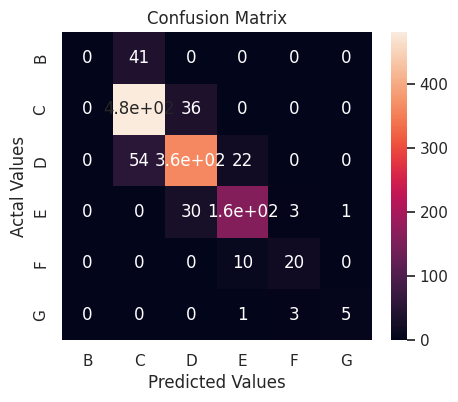

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(svm_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

##Model Explainability -  SVM Feature Importance


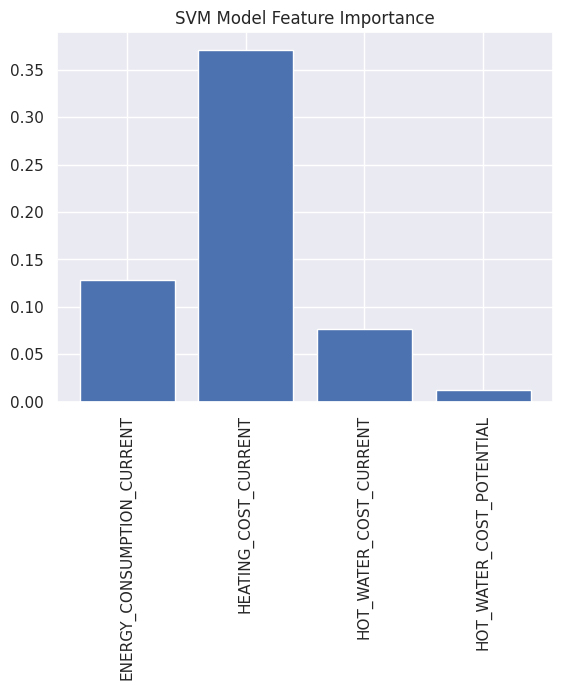

In [ ]:
# permutation feature importance with SVM for classification
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

# perform permutation importance
results = permutation_importance(train_svm, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

# summarize feature importance in Pandas Data Frame
feature_df = pd.DataFrame({'Importance':importance, 'Features': X_train.columns })
feature_df = feature_df[feature_df['Importance'] > 0.01]

# plot feature importance
sns.set()
plt.bar(feature_df['Features'],  feature_df['Importance'])
plt.xticks(rotation=90)
plt.title('SVM Model Feature Importance')
plt.show()

#Model Building - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(random_state=42)

##Training Data

In [ ]:
lgrStart = time.time()

In [ ]:
train_lgr = lgr.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
lgrEnd = time.time()

In [ ]:
lgrTimeTaken = lgrStart - lgrEnd
lgrTimeTaken

-0.38837122917175293

##Validating Data

In [ ]:
lgr_val_pred = lgr.predict(X_val)

In [ ]:
lgr_val_acc = accuracy_score(y_val, lgr_val_pred)
lgr_val_prec = precision_score(y_val, lgr_val_pred, average='weighted')
lgr_val_rec = recall_score(y_val, lgr_val_pred, average='weighted')
lgr_val_f1 = f1_score(y_val, lgr_val_pred, average='weighted')

In [ ]:
print(lgr_val_acc, '\n', lgr_val_prec, '\n', lgr_val_rec, '\n', lgr_val_f1)

0.8908794788273615 
 0.8901256678024946 
 0.8908794788273615 
 0.8902852669283824


In [ ]:
lgr_val_clfrprt = classification_report(y_val, lgr_val_pred, target_names=target_names)
print(lgr_val_clfrprt)

              precision    recall  f1-score   support

           B       0.86      0.73      0.79        41
           C       0.93      0.94      0.93       516
           D       0.89      0.89      0.89       437
           E       0.85      0.85      0.85       195
           F       0.62      0.60      0.61        30
           G       0.75      0.67      0.71         9

    accuracy                           0.89      1228
   macro avg       0.82      0.78      0.80      1228
weighted avg       0.89      0.89      0.89      1228



In [ ]:
lgr_confmatrix = confusion_matrix(y_val, lgr_val_pred)
lgr_confmatrix

array([[ 30,  11,   0,   0,   0,   0],
       [  5, 486,  25,   0,   0,   0],
       [  0,  28, 389,  20,   0,   0],
       [  0,   0,  22, 165,   8,   0],
       [  0,   0,   0,  10,  18,   2],
       [  0,   0,   0,   0,   3,   6]])

In [ ]:
lgr_confmatrix_df = pd.DataFrame(lgr_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])


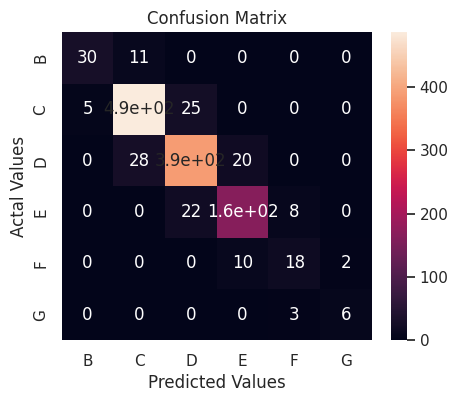

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(lgr_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


In [ ]:
lgr_multi_confusion = multilabel_confusion_matrix(y_val, lgr_val_pred)
lgr_multi_confusion


array([[[1182,    5],
        [  11,   30]],

       [[ 673,   39],
        [  30,  486]],

       [[ 744,   47],
        [  48,  389]],

       [[1003,   30],
        [  30,  165]],

       [[1187,   11],
        [  12,   18]],

       [[1217,    2],
        [   3,    6]]])

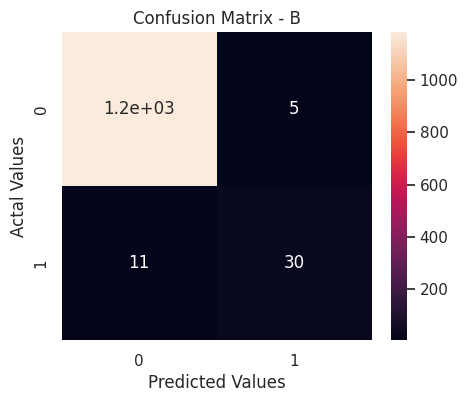

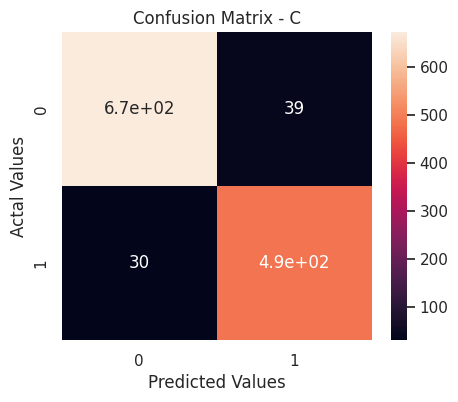

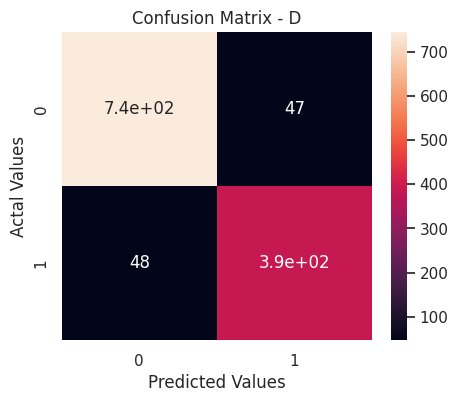

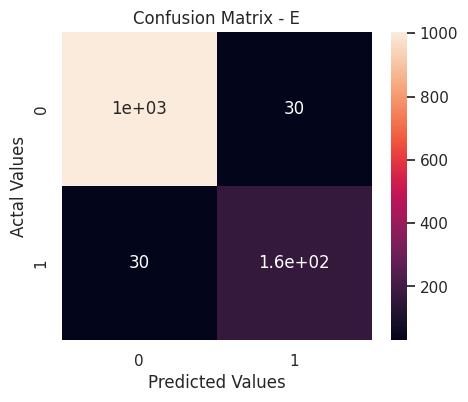

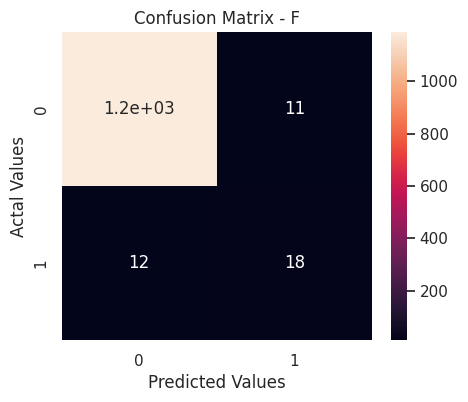

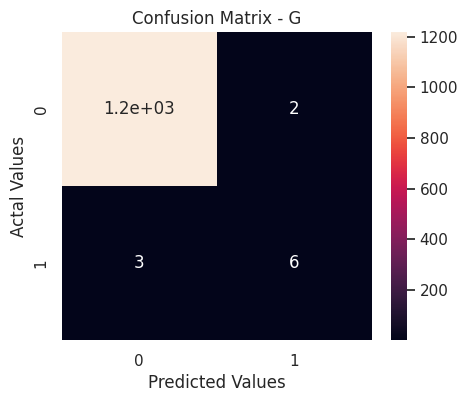

In [ ]:
for i in range (0, 6, 1):
  plt.figure(figsize=(5,4))
  sns.heatmap(lgr_multi_confusion[i], annot=True)
  plt.title('Confusion Matrix - ' + target_names[i])
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  print('\n')


##Model Testing - LGR

In [ ]:
lgr_test_pred = lgr.predict(X_test)

In [ ]:
lgr_test_acc = accuracy_score(y_test, lgr_test_pred)
lgr_test_prec = precision_score(y_test, lgr_test_pred, average='weighted')
lgr_test_rec = recall_score(y_test, lgr_test_pred, average='weighted')
lgr_test_f1 = f1_score(y_test, lgr_test_pred, average='weighted')

In [ ]:
print(lgr_test_acc, '\n', lgr_test_prec, '\n', lgr_test_rec, '\n', lgr_test_f1)

0.8908794788273615 
 0.8901256678024946 
 0.8908794788273615 
 0.8902852669283824


In [ ]:
lgr_test_clfrprt = classification_report(y_test, lgr_test_pred, target_names=target_names)
print(lgr_test_clfrprt)

              precision    recall  f1-score   support

           B       0.86      0.73      0.79        41
           C       0.93      0.94      0.93       516
           D       0.89      0.89      0.89       437
           E       0.85      0.85      0.85       195
           F       0.62      0.60      0.61        30
           G       0.75      0.67      0.71         9

    accuracy                           0.89      1228
   macro avg       0.82      0.78      0.80      1228
weighted avg       0.89      0.89      0.89      1228



In [ ]:
lgr_confmatrix = confusion_matrix(y_test, lgr_test_pred)
lgr_confmatrix

array([[ 30,  11,   0,   0,   0,   0],
       [  5, 486,  25,   0,   0,   0],
       [  0,  28, 389,  20,   0,   0],
       [  0,   0,  22, 165,   8,   0],
       [  0,   0,   0,  10,  18,   2],
       [  0,   0,   0,   0,   3,   6]])

In [ ]:
lgr_confmatrix_df = pd.DataFrame(lgr_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])

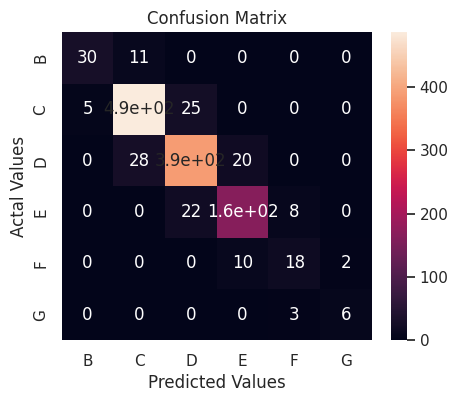

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(lgr_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

##Model Explainability -  Log Reg Feature Importance


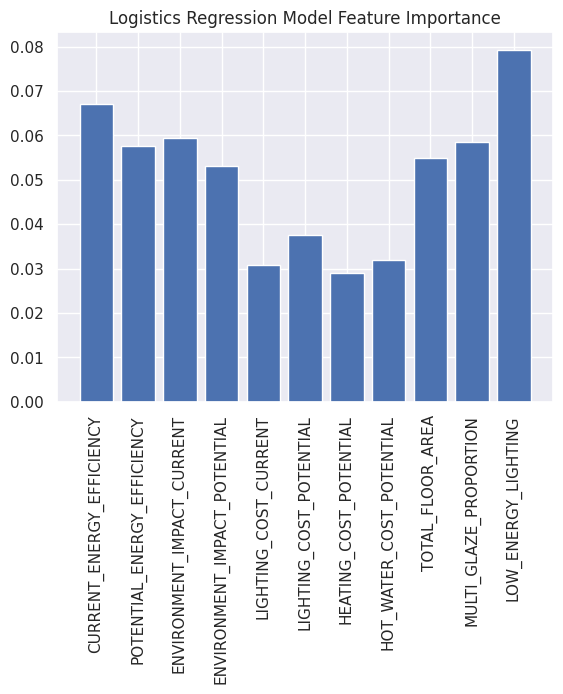

In [ ]:
# get importance
importance = lgr.coef_[0]

# summarize feature importance in Pandas Data Frame
feature_df = pd.DataFrame({'Importance':importance,
'Features': X_train.columns })
feature_df = feature_df[feature_df['Importance'] > 0.01]

# plot feature importance
sns.set()
plt.bar(feature_df['Features'],  feature_df['Importance'])
plt.xticks(rotation=90)
plt.title('Logistics Regression Model Feature Importance')
plt.show()

#Model Building - Naive Bayes

In [ ]:
from sklearn.naive_bayes import CategoricalNB
nb = CategoricalNB()


##Training Data

In [ ]:
nbStart = time.time()

In [ ]:
train_nb = nb.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
nbEnd = time.time()

In [ ]:
nbTimeTaken = nbStart - nbEnd
nbTimeTaken

-0.10428214073181152

##Validating Data

In [ ]:
nb_val_pred = nb.predict(X_val)

In [ ]:
nb_val_acc = accuracy_score(y_val, nb_val_pred)
nb_val_prec = precision_score(y_val, nb_val_pred, average='weighted')
nb_val_rec = recall_score(y_val, nb_val_pred, average='weighted')
nb_val_f1 = f1_score(y_val, nb_val_pred, average='weighted')

In [ ]:
print(nb_val_acc, '\n', nb_val_prec, '\n', nb_val_rec, '\n', nb_val_f1)

0.8623778501628665 
 0.8825546836480751 
 0.8623778501628665 
 0.8674543360714752


In [ ]:
nb_val_clfrprt = classification_report(y_val, nb_val_pred, target_names=target_names)
print(nb_val_clfrprt)


              precision    recall  f1-score   support

           B       0.92      0.80      0.86        41
           C       0.96      0.94      0.95       516
           D       0.92      0.80      0.85       437
           E       0.61      0.84      0.70       195
           F       0.68      0.70      0.69        30
           G       1.00      0.67      0.80         9

    accuracy                           0.86      1228
   macro avg       0.85      0.79      0.81      1228
weighted avg       0.88      0.86      0.87      1228



In [ ]:
nb_confmatrix = confusion_matrix(y_val, nb_val_pred)
nb_confmatrix


array([[ 33,   7,   0,   1,   0,   0],
       [  2, 487,   1,  23,   3,   0],
       [  1,  11, 348,  71,   6,   0],
       [  0,   0,  30, 164,   1,   0],
       [  0,   0,   0,   9,  21,   0],
       [  0,   0,   0,   3,   0,   6]])

In [ ]:
nb_confmatrix_df = pd.DataFrame(nb_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])


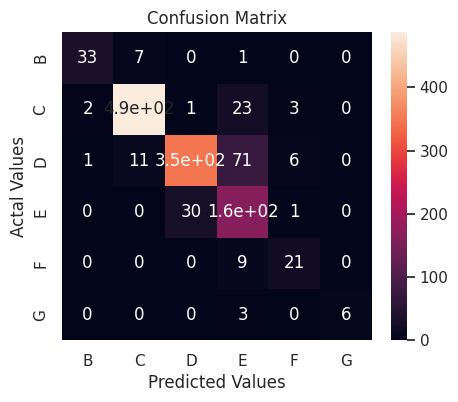

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(nb_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


In [ ]:
nb_multi_confusion = multilabel_confusion_matrix(y_val, nb_val_pred)
nb_multi_confusion

array([[[1184,    3],
        [   8,   33]],

       [[ 694,   18],
        [  29,  487]],

       [[ 760,   31],
        [  89,  348]],

       [[ 926,  107],
        [  31,  164]],

       [[1188,   10],
        [   9,   21]],

       [[1219,    0],
        [   3,    6]]])

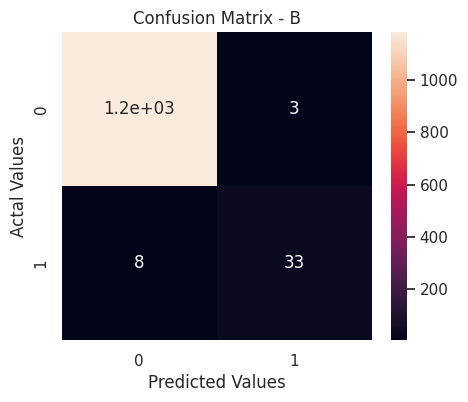

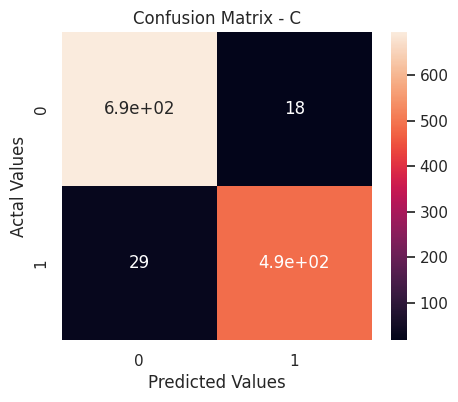

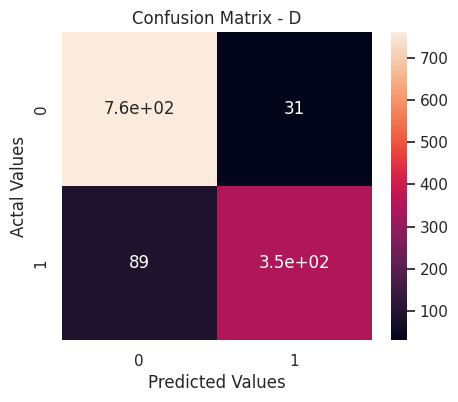

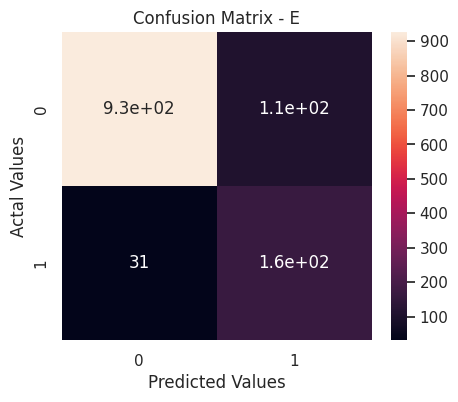

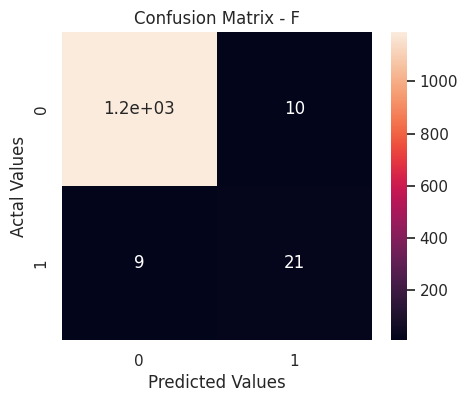

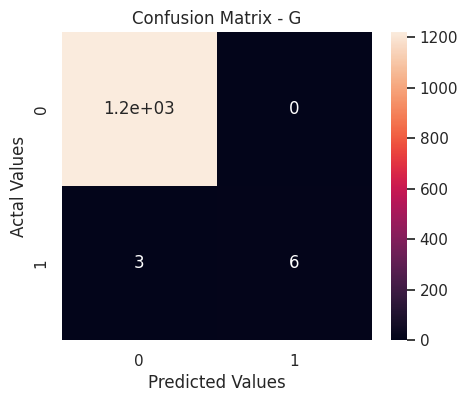

In [ ]:
for i in range (0, 6, 1):
  plt.figure(figsize=(5,4))
  sns.heatmap(nb_multi_confusion[i], annot=True)
  plt.title('Confusion Matrix - ' + target_names[i])
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  print('\n')


##Model Testing - NB

In [ ]:
nb_test_pred = nb.predict(X_test)

In [ ]:
nb_test_acc = accuracy_score(y_test, nb_test_pred)
nb_test_prec = precision_score(y_test, nb_test_pred, average='weighted')
nb_test_rec = recall_score(y_test, nb_test_pred, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_pred, average='weighted')

In [ ]:
print(nb_test_acc, '\n', nb_test_prec, '\n', nb_test_rec, '\n', nb_test_f1)

0.8623778501628665 
 0.8825546836480751 
 0.8623778501628665 
 0.8674543360714752


In [ ]:
nb_test_clfrprt = classification_report(y_test, nb_test_pred, target_names=target_names)
print(nb_test_clfrprt)

              precision    recall  f1-score   support

           B       0.92      0.80      0.86        41
           C       0.96      0.94      0.95       516
           D       0.92      0.80      0.85       437
           E       0.61      0.84      0.70       195
           F       0.68      0.70      0.69        30
           G       1.00      0.67      0.80         9

    accuracy                           0.86      1228
   macro avg       0.85      0.79      0.81      1228
weighted avg       0.88      0.86      0.87      1228



In [ ]:
nb_confmatrix = confusion_matrix(y_test, nb_test_pred)
nb_confmatrix

array([[ 33,   7,   0,   1,   0,   0],
       [  2, 487,   1,  23,   3,   0],
       [  1,  11, 348,  71,   6,   0],
       [  0,   0,  30, 164,   1,   0],
       [  0,   0,   0,   9,  21,   0],
       [  0,   0,   0,   3,   0,   6]])

In [ ]:
nb_confmatrix_df = pd.DataFrame(nb_confmatrix,
                     index = ['B','C','D','E','F','G'],
                     columns = ['B','C','D','E','F','G'])

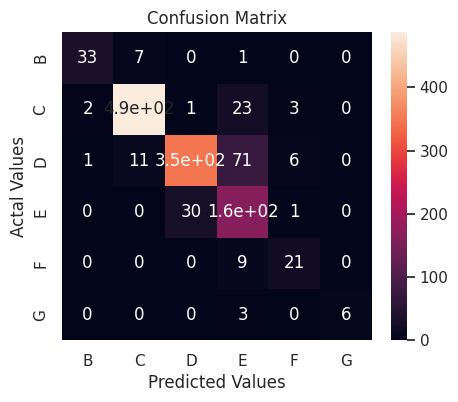

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(nb_confmatrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

##Model Explainability -  NB Feature Importance





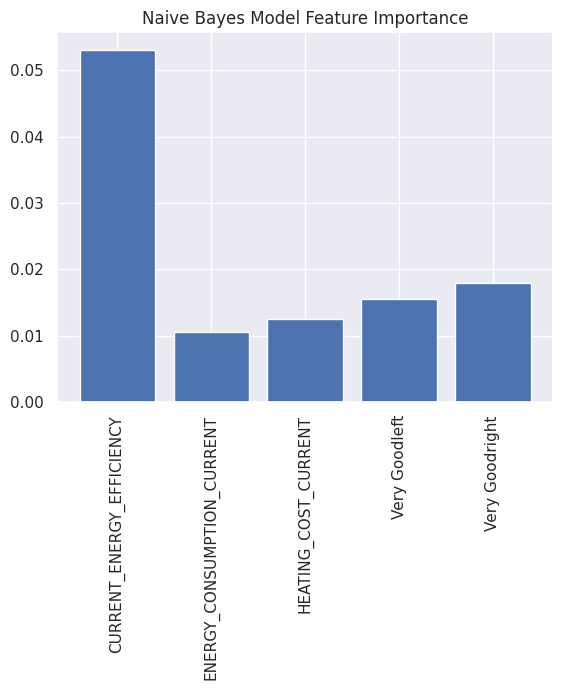

In [ ]:
# permutation feature importance with NB for classification
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

# perform permutation importance
results = permutation_importance(train_nb, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

# summarize feature importance in Pandas Data Frame
feature_df = pd.DataFrame({'Importance':importance, 'Features': X_train.columns })
feature_df = feature_df[feature_df['Importance'] > 0.01]

# plot feature importance
sns.set()
plt.bar(feature_df['Features'],  feature_df['Importance'])
plt.xticks(rotation=90)
plt.title('Naive Bayes Model Feature Importance')
plt.show()